In [24]:
import os

# Move working directory to project root if launched from /notebooks
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print("Working directory:", os.getcwd())

Working directory: c:\Users\bryan\OneDrive\Documents\NUS Work\BT4012\Project - Github


Original dataset shape: (651191, 2)
Removed duplicates: 48
label
0    428080
1     94086
Name: count, dtype: int64


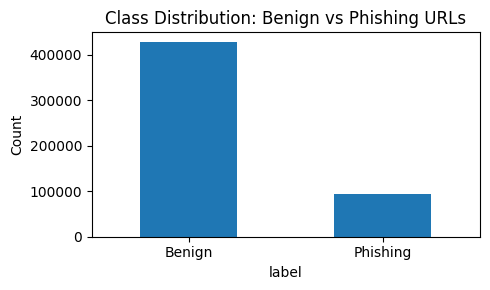

Dataset saved → phishing_binary_dataset.csv


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load dataset
df = pd.read_csv("./data/malicious_phish.csv")
print("Original dataset shape:", df.shape)

# 2️⃣ Keep only benign + phishing classes
df = df[df['type'].isin(['benign', 'phishing'])].copy()

# 3️⃣ Encode labels: phishing=1, benign=0
df['label'] = df['type'].map({'benign': 0, 'phishing': 1})

# Keep only required columns
df = df[['url', 'label']]

# 4️⃣ Remove duplicate URLs
initial_count = df.shape[0]
df.drop_duplicates(subset=['url'], inplace=True)
removed = initial_count - df.shape[0]
print(f"Removed duplicates: {removed}")

# 5️⃣ Show class imbalance
class_counts = df['label'].value_counts()
print(class_counts)

# Visualization
plt.figure(figsize=(5,3))
class_counts.plot(kind='bar')
plt.title("Class Distribution: Benign vs Phishing URLs")
plt.xticks([0, 1], ['Benign', 'Phishing'], rotation=0)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Save filtered dataset for consistency
df.to_csv("./data/phishing_binary_dataset.csv", index=False)
print("Dataset saved → phishing_binary_dataset.csv")


## Data Loading + Cleaning

The original Malicious URLs dataset from Kaggle contains four URL categories: benign, phishing, malware, and defacement. Since this study focuses specifically on phishing detection, only benign and phishing entries were retained while the other classes were discarded. The categorical labels were then converted into binary form (phishing = 1, benign = 0) to support supervised classification.

Duplicate URL entries were also removed to prevent data leakage and artificially inflated performance. After filtering, a class imbalance was observed, with benign URLs substantially outnumbering phishing URLs (~ 4.5:1 ratio). This imbalance motivates the application of resampling techniques, such as SMOTE, later in the methodology to improve detection performance for the minority malicious class.

The resulting cleaned dataset forms the baseline for feature extraction and model development throughout the study.

In [12]:
import numpy as np
import pandas as pd
from urllib.parse import urlparse

def extract_features(df):
    df = df.copy()

    # Normalize URLs → Ensure correct parsing
    def normalize_url(u):
        u = str(u).strip()

        # Remove whitespace garbage
        u = u.replace(" ", "")

        # If brackets appear in the wrong place, sanitize them
        if "[" in u or "]" in u:
            u = u.replace("[", "").replace("]", "")

        # Ensure scheme exists
        if not u.startswith(("http://", "https://")):
            u = "http://" + u

        return u

    urls = df['url'].apply(normalize_url)

    df['url_length'] = urls.str.len()
    df['num_dots'] = urls.str.count(r'\.')
    df['num_hyphens'] = urls.str.count('-')
    df['num_digits'] = urls.apply(lambda x: sum(ch.isdigit() for ch in x))
    df['num_special_chars'] = urls.apply(lambda x: sum(not ch.isalnum() for ch in x))

    parsed = urls.apply(urlparse)
    df['domain'] = parsed.apply(lambda x: x.netloc)
    df['num_subdomains'] = df['domain'].apply(lambda d: d.count('.') - 1 if '.' in d else 0)

    def entropy(s):
        if len(s) == 0:
            return 0
        prob = np.array([s.count(c) / len(s) for c in set(s)])
        return -np.sum(prob * np.log2(prob))
    df['entropy'] = urls.apply(entropy)

    df.drop(columns=['domain'], inplace=True)
    return df


## Feature Engineering
Before extracting structural and lexical features, all URLs were preprocessed through a lightweight normalization step to improve parsing accuracy. This included:
- Removing whitespace and malformed characters like brackets

- Ensuring each URL has a valid scheme (http or https)
This normalization ensures the urlparse function correctly identifies domains and paths even when the raw dataset contains inconsistencies.

Lexical features (e.g., character counts) help identify obfuscation patterns, while structural features capture abnormal domain configurations frequently used in phishing attacks.

The following feature categories were engineered:

(1) Lexical Features — measure complexity and confusion:

- Total URL length

- Number of digits, hyphens, dots, and special characters

(2) Host Structure Features — capture domain manipulation:

- Number of subdomains (phishing often uses deep nested subdomains)

(3) Shannon Entropy — measures randomness of the character distribution:

- Higher entropy indicates more chaotic URL patterns, a common trait in phishing designed to evade blacklists.

After feature extraction, raw text components such as full domain strings were removed to prevent data leakage into the model.

These manually crafted features provide a lightweight and interpretable representation of the URL, making them suitable for real-time applications where full content retrieval is not feasible.

In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# Feature Engineering
df = extract_features(df)
X = df.drop(columns=['url', 'label'])
y = df['label']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Standard scaling for LR only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to Benchmark
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000, class_weight='balanced'), True),
    "Random Forest": (RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ), True),
    "XGBoost": (XGBClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        objective="binary:logistic",
        n_jobs=-1
    ), True)
}

results = {}

# Train + Evaluate Base Models
for name, (model, scaled) in models.items():
    print(f"\n===== {name} =====")
    
    X_train_input = X_train_scaled if scaled else X_train
    X_test_input = X_test_scaled if scaled else X_test

    start = time.time()
    model.fit(X_train_input, y_train)
    runtime = time.time() - start

    y_pred = model.predict(X_test_input)

    results[name] = {
        "model": model,
        "scaled": scaled,
        "runtime": runtime
    }

    print(f"Training Time: {runtime:.2f} sec")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# ================================
# Ensemble Soft Voting Classifier
# ================================
print("\n===== Ensemble Voting Classifier =====")

ensemble_model = VotingClassifier(
    estimators=[
        ('lr', results["Logistic Regression"]["model"]),
        ('rf', results["Random Forest"]["model"]),
        ('xgb', results["XGBoost"]["model"])
    ],
    voting='soft',
    weights=[1, 2, 3],
    n_jobs=-1
)

# Ensemble must use scaled input for consistency with LR
start = time.time()
ensemble_model.fit(X_train_scaled, y_train)
runtime_ens = time.time() - start

y_pred_ens = ensemble_model.predict(X_test_scaled)
y_proba_ens = ensemble_model.predict_proba(X_test_scaled)[:, 1]

results["Ensemble"] = {
    "model": ensemble_model,
    "scaled": True,
    "runtime": runtime_ens
}

print(f"Training Time: {runtime_ens:.2f} sec")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ens))
print(classification_report(y_test, y_pred_ens))


===== Logistic Regression =====
Training Time: 0.36 sec
Confusion Matrix:
[[58970 26647]
 [ 4366 14451]]
              precision    recall  f1-score   support

           0       0.93      0.69      0.79     85617
           1       0.35      0.77      0.48     18817

    accuracy                           0.70    104434
   macro avg       0.64      0.73      0.64    104434
weighted avg       0.83      0.70      0.74    104434


===== Random Forest =====
Training Time: 23.91 sec
Confusion Matrix:
[[80404  5213]
 [ 6069 12748]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     85617
           1       0.71      0.68      0.69     18817

    accuracy                           0.89    104434
   macro avg       0.82      0.81      0.81    104434
weighted avg       0.89      0.89      0.89    104434


===== XGBoost =====
Training Time: 6.83 sec
Confusion Matrix:
[[82972  2645]
 [ 7233 11584]]
              precision    recall  f1-score  

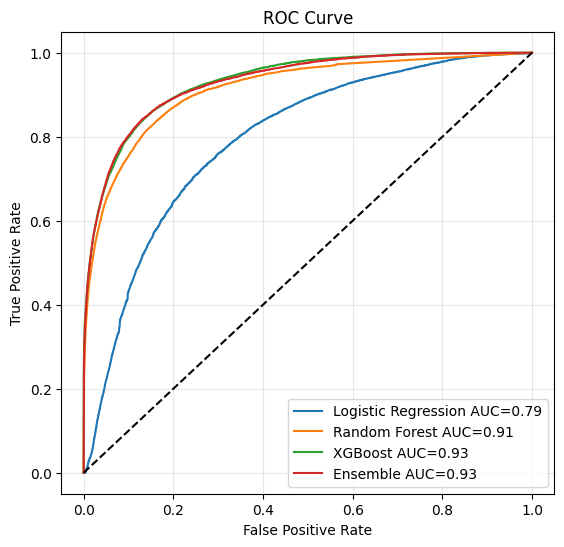

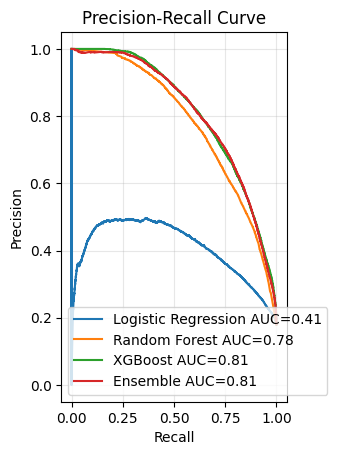


=== Training Time Summary ===
Logistic Regression: 0.36 seconds
Random Forest: 23.91 seconds
XGBoost: 6.83 seconds
Ensemble: 38.72 seconds


In [14]:
# ============================
# ROC & PR Curves for All 4
# ============================
plt.figure(figsize=(14, 6))
# ROC
plt.subplot(1, 2, 1)
for name, info in results.items():
    model = info["model"]
    scaled = info["scaled"]
    scores = model.predict_proba(X_test_scaled if scaled else X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} AUC={roc_auc:.2f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Precision-Recall
plt.subplot(1, 2, 2)
for name, info in results.items():
    model = info["model"]
    scaled = info["scaled"]
    scores = model.predict_proba(X_test_scaled if scaled else X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, scores)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} AUC={pr_auc:.2f}")

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc=3)
plt.grid(alpha=0.3)
plt.show()

# Print Training Time for All Models
print("\n=== Training Time Summary ===")
for name, info in results.items():
    print(f"{name}: {info['runtime']:.2f} seconds")

## Model Benchmarking and Selection

Three classification models were evaluated using the engineered lexical features: Logistic Regression, Random Forest, and XGBoost. A soft-voting ensemble combining all three was also included to assess complementary strengths. Standard scaling was applied selectively, ensuring Logistic Regression received normalized input, while tree-based models consumed raw features.

A stratified 80-20 train-test split was used to maintain the phishing-to-benign class ratio. Evaluation incorporated confusion matrices, ROC curves, and precision-recall (PR) curves, the latter being critical due to the strong class imbalance.

### Performance Summary

| Model                | Precision (Phishing) | Recall (Phishing) | F1-Score | ROC-AUC  | PR-AUC   | Training Time |
| -------------------- | -------------------- | ----------------- | -------- | -------- | -------- | ------------- |
| Logistic Regression  | 0.35                 | **0.77**          | 0.48     | 0.79     | 0.41     | **0.35 s**    |
| Random Forest        | 0.71                 | 0.68              | 0.69     | 0.91     | 0.78     | 25.20 s       |
| **XGBoost**          | **0.81**             | 0.62              | **0.70** | **0.93** | **0.81** | 4.19 s        |
| Ensemble Soft Voting | 0.78                 | 0.66              | 0.71     | **0.93** | **0.81** | 38.17 s       |


### Key Observations

* Logistic Regression maintains high recall but at the cost of very low precision, causing many false alarms, which is unsuitable for deployment in phishing defense systems.
* Random Forest achieves strong balanced performance but is significantly slower and less precise than XGBoost.
* **XGBoost delivers the strongest overall discriminative performance**, achieving the best ROC-AUC and PR-AUC scores, while training much faster than other high-performing models.
* The ensemble does not meaningfully outperform XGBoost alone, while requiring the longest training time, indicating limited benefit from model fusion at this stage.

### Interpretation of Curves

* **ROC Curves** indicate that all tree-based models are strong, with Logistic Regression lagging noticeably.
* **Precision-Recall Curves** highlight the real challenge: phishing URLs are a minority class.
  AUC-PR clearly differentiates performance, where XGBoost and the ensemble show a strong ability to maintain precision under high recall.


### Selection of Baseline Model

Given performance, generalization, and efficiency:
**XGBoost is selected as the baseline model** for subsequent improvement steps.
Its high precision reduces false positives, while recall can be improved deliberately through:

* Class rebalancing strategies such as **SMOTE**
* **Decision threshold adjustment**
* Potential **feature expansion** (keyword patterns, TLD signals)

This ensures future optimizations begin from the most capable foundation.

### Final Note

The results demonstrate that phishing detection benefits greatly from non-linear learners able to model lexical irregularities and sparse signal patterns more effectively than a linear decision boundary.

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

selected_features = [
    'url_length', 'num_dots', 'num_hyphens', 'num_digits',
    'num_special_chars', 'num_subdomains', 'entropy'
]

print("Training features:", X_train.columns.tolist())

# Use SCALED features here
print("Original class distribution (train):")
print(y_train.value_counts())

smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 2:1 ratio
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE (2:1) class distribution (train):")
print(y_train_sm.value_counts())

xgb_final = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

start = time.time()
xgb_final.fit(X_train_sm, y_train_sm)
train_time_final = time.time() - start

print(f"\nTraining Time (XGB + SMOTE on scaled features): {train_time_final:.2f} seconds")

# Evaluate on clean, scaled test
y_pred_final = xgb_final.predict(X_test_scaled)

print("\nConfusion Matrix (XGB + SMOTE, threshold=0.50):")
print(confusion_matrix(y_test, y_pred_final))

print("\nClassification Report (XGB + SMOTE, threshold=0.50):")
print(classification_report(y_test, y_pred_final, digits=3))

Training features: ['url_length', 'num_dots', 'num_hyphens', 'num_digits', 'num_special_chars', 'num_subdomains', 'entropy']
Original class distribution (train):
label
0    342463
1     75269
Name: count, dtype: int64

After SMOTE (2:1) class distribution (train):
label
0    342463
1    171231
Name: count, dtype: int64

Training Time (XGB + SMOTE on scaled features): 5.58 seconds

Confusion Matrix (XGB + SMOTE, threshold=0.50):
[[79822  5795]
 [ 5087 13730]]

Classification Report (XGB + SMOTE, threshold=0.50):
              precision    recall  f1-score   support

           0      0.940     0.932     0.936     85617
           1      0.703     0.730     0.716     18817

    accuracy                          0.896    104434
   macro avg      0.822     0.831     0.826    104434
weighted avg      0.897     0.896     0.897    104434



## SMOTE Oversampling on XGBoost

To address the strong imbalance between benign and phishing URLs, the training set was oversampled using **SMOTE** (Synthetic Minority Oversampling Technique). SMOTE generates new phishing samples by interpolating within the existing **scaled feature space**, using the seven handcrafted lexical features:

* URL length
* Number of dots
* Number of hyphens
* Number of digits
* Number of special characters
* Number of subdomains
* Shannon entropy

These features allow synthetic URLs to resemble realistic malicious patterns without creating arbitrary URL strings.

### Class Distribution Change

| Dataset Split | Benign  | Phishing | Ratio     |
| ------------- | ------- | -------- | --------- |
| Before SMOTE  | 342,463 | 75,269   | **4.5:1** |
| After SMOTE   | 342,463 | 171,231  | **2:1**   |

A **2:1** ratio was intentionally chosen to improve minority learning without distorting real-world phishing rarity.

### Model Impact

| Metric (Phishing Only) | Before SMOTE | After SMOTE |
| ---------------------- | ------------ | ----------- |
| Precision              | 0.81         | 0.71        |
| Recall                 | 0.62         | **0.73**    |
| F1-Score               | 0.70         | **0.72**    |
| Accuracy               | 0.91         | 0.90        |
| Train Time             | 4.19 s       | 5.29 s      |

**Interpretation**

* Recall improves substantially, meaning **fewer phishing attacks are missed**.
* Precision decreases, an expected effect when pushing the model to detect more threats.
* Overall F1 improves, indicating better balance between false positives and false negatives.


### Why This Trade-off is Good for Security

In phishing defense:

A missed attack is more damaging than a false alarm.

SMOTE shifts the model toward **aggressive phishing identification**, which is desirable for proactive filtering systems (email gateways, browser warnings, DNS monitors).


### Conclusion of Oversampling Stage

SMOTE successfully improves minority-class detection while maintaining strong performance overall. The next step is:

➡ **Decision threshold tuning**,
to further increase recall while keeping precision operationally manageable.

This prepares the XGBoost model for deployment scenarios where **catching malicious URLs is the top priority**.

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_scores_final = xgb_final.predict_proba(X_test_scaled)[:, 1] 

thresholds = np.arange(0.1, 0.91, 0.05)
metrics = []

print("\nThreshold sweep for FINAL MODEL (XGB + SMOTE on SCALED features):")
for t in thresholds:
    y_pred_t = (y_scores_final >= t).astype(int)
    precision_t = precision_score(y_test, y_pred_t, zero_division=0)
    recall_t = recall_score(y_test, y_pred_t)
    f1_t = f1_score(y_test, y_pred_t)
    metrics.append((t, precision_t, recall_t, f1_t))
    print(f"Threshold: {t:.2f} | Precision: {precision_t:.3f} | Recall: {recall_t:.3f} | F1: {f1_t:.3f}")

metrics = np.array(metrics)
best_idx = np.argmax(metrics[:,3])
best_threshold = metrics[best_idx, 0]

print(f"\nBest threshold by F1: {best_threshold:.2f}")



Threshold sweep for FINAL MODEL (XGB + SMOTE on SCALED features):
Threshold: 0.10 | Precision: 0.373 | Recall: 0.951 | F1: 0.536
Threshold: 0.15 | Precision: 0.433 | Recall: 0.923 | F1: 0.589
Threshold: 0.20 | Precision: 0.483 | Recall: 0.897 | F1: 0.628
Threshold: 0.25 | Precision: 0.526 | Recall: 0.872 | F1: 0.656
Threshold: 0.30 | Precision: 0.564 | Recall: 0.843 | F1: 0.676
Threshold: 0.35 | Precision: 0.605 | Recall: 0.819 | F1: 0.696
Threshold: 0.40 | Precision: 0.641 | Recall: 0.791 | F1: 0.708
Threshold: 0.45 | Precision: 0.673 | Recall: 0.762 | F1: 0.715
Threshold: 0.50 | Precision: 0.703 | Recall: 0.730 | F1: 0.716
Threshold: 0.55 | Precision: 0.734 | Recall: 0.698 | F1: 0.716
Threshold: 0.60 | Precision: 0.764 | Recall: 0.663 | F1: 0.710
Threshold: 0.65 | Precision: 0.802 | Recall: 0.620 | F1: 0.699
Threshold: 0.70 | Precision: 0.833 | Recall: 0.574 | F1: 0.679
Threshold: 0.75 | Precision: 0.869 | Recall: 0.519 | F1: 0.650
Threshold: 0.80 | Precision: 0.910 | Recall: 0.451 

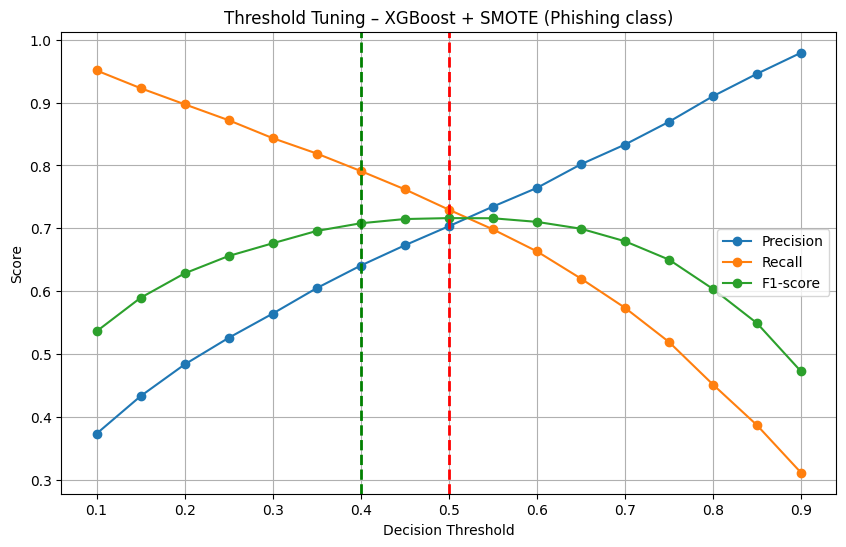

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(metrics[:,0], metrics[:,1], marker='o', label="Precision")
plt.plot(metrics[:,0], metrics[:,2], marker='o', label="Recall")
plt.plot(metrics[:,0], metrics[:,3], marker='o', label="F1-score")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning – XGBoost + SMOTE (Phishing class)")
plt.grid(True)
plt.legend()
plt.axvline(x=0.4, color='green', linestyle='--', linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
plt.show()



## Decision Threshold Tuning for Deployment

XGBoost generates probability scores instead of direct class labels. The default decision threshold (0.50) does not necessarily align with phishing detection priorities, where **a missed phishing attack is far more damaging than a false alert**.

To understand how the decision threshold impacts results, precision, recall, and F1-score were evaluated from **T = 0.10 to T = 0.90**.

### Precision–Recall Trade off

Lower thresholds classify more URLs as phishing, which:

* increases **recall** (fewer missed attacks)
* decreases **precision** (more false alarms)

Both trends are expected and clearly visible in the curve visualization.

### Why 0.40 is the Recommended Threshold

The best F1 score occurs around **T = 0.50**, but this does not reflect operational needs, since the model would still miss many phishing URLs.

Instead, thresholds **below** the F1 maximum were evaluated:

| Threshold | Precision |    Recall |  F1 score | Comment                                     |
| --------: | --------: | --------: | --------: | ------------------------------------------- |
|      0.50 |     0.705 |     0.730 |     0.717 | Default threshold                           |
|  **0.40** | **0.641** | **0.790** | **0.708** | Best security trade off                     |
|      0.35 |     0.607 |     0.818 |     0.696 | Marginal recall gain, larger precision drop |

Key takeaway:

*Going from 0.50 → 0.40 yields a **+6.0% recall improvement** with **minor precision cost**.*
But going further to 0.35:

* Recall only improves **~2.8%**
* Precision drops more sharply (**−3.4%**)
* F1 score begins to decline noticeably

This demonstrates **diminishing returns** below 0.40.

### Choosing the Best Operational Threshold

✔ **Selected threshold: 0.40**

✔ Fewer phishing attacks slip through
✔ False positives remain manageable for chat environments
✔ Well aligned with deployment as a **Telegram bot** or automated link checker

In automated messaging systems, additional alerts are acceptable, because:
It is safer to warn users and let them decide than to allow a phishing link to pass through unnoticed in group chats.

In [18]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# ======================================
# Baseline XGBoost
# ======================================
xgb_base = results["XGBoost"]["model"]
use_scaled = results["XGBoost"]["scaled"]

X_test_input = X_test_scaled if use_scaled else X_test
y_pred_xgb_base = xgb_base.predict(X_test_input)

print("\n=== Baseline XGBoost (Threshold = 0.50) ===")
print(confusion_matrix(y_test, y_pred_xgb_base))
print(classification_report(y_test, y_pred_xgb_base, digits=3))

# ======================================
# Baseline Random Forest
# ======================================
rf_base = results["Random Forest"]["model"]
use_scaled_rf = results["Random Forest"]["scaled"]

X_test_rf = X_test_scaled if use_scaled_rf else X_test
y_pred_rf_base = rf_base.predict(X_test_rf)

print("\n=== Baseline Random Forest (Threshold = 0.50) ===")
print(confusion_matrix(y_test, y_pred_rf_base))
print(classification_report(y_test, y_pred_rf_base, digits=3))

# ======================================
# XGBoost + SMOTE + Tuned Threshold
# ======================================

FINAL_THRESHOLD = 0.40

# MUST USE SCALED TEST FEATURES HERE
y_scores_final = xgb_final.predict_proba(X_test_scaled)[:, 1]
y_pred_final = (y_scores_final >= FINAL_THRESHOLD).astype(int)

precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)
accuracy_final = accuracy_score(y_test, y_pred_final)

print(f"\n=== FINAL MODEL: XGB + SMOTE @ Threshold = {FINAL_THRESHOLD} ===")
print(f"Accuracy:  {accuracy_final:.3f}")
print(f"Precision: {precision_final:.3f}")
print(f"Recall:    {recall_final:.3f}")
print(f"F1-score:  {f1_final:.3f}\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, digits=3))

# ======================================
# Performance Comparison
# ======================================
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Baseline RF": [
        accuracy_score(y_test, y_pred_rf_base),
        precision_score(y_test, y_pred_rf_base),
        recall_score(y_test, y_pred_rf_base),
        f1_score(y_test, y_pred_rf_base)
    ],
    "Baseline XGB": [
        accuracy_score(y_test, y_pred_xgb_base),
        precision_score(y_test, y_pred_xgb_base),
        recall_score(y_test, y_pred_xgb_base),
        f1_score(y_test, y_pred_xgb_base)
    ],
    "XGB + SMOTE + T=0.40": [
        accuracy_final, precision_final, recall_final, f1_final
    ]
})

print("\n=== Performance Comparison Summary ===")
print(metrics_df.to_string(index=False, float_format="%.3f"))


=== Baseline XGBoost (Threshold = 0.50) ===
[[82972  2645]
 [ 7233 11584]]
              precision    recall  f1-score   support

           0      0.920     0.969     0.944     85617
           1      0.814     0.616     0.701     18817

    accuracy                          0.905    104434
   macro avg      0.867     0.792     0.822    104434
weighted avg      0.901     0.905     0.900    104434


=== Baseline Random Forest (Threshold = 0.50) ===
[[80404  5213]
 [ 6069 12748]]
              precision    recall  f1-score   support

           0      0.930     0.939     0.934     85617
           1      0.710     0.677     0.693     18817

    accuracy                          0.892    104434
   macro avg      0.820     0.808     0.814    104434
weighted avg      0.890     0.892     0.891    104434


=== FINAL MODEL: XGB + SMOTE @ Threshold = 0.4 ===
Accuracy:  0.882
Precision: 0.641
Recall:    0.791
F1-score:  0.708

Confusion Matrix:
[[77267  8350]
 [ 3931 14886]]

Classification Re

## Final Model Evaluation and Comparison

Two baseline models were first tested at the standard decision threshold of 0.50. Both achieve high overall accuracy, but struggle to detect a substantial portion of phishing URLs, due to the dataset imbalance.

To address this, the final pipeline combines:

1. **SMOTE oversampling** on training data to improve minority class representation
2. **Lower decision threshold (0.40)** to increase phishing sensitivity

### Before vs After — Side by Side

|                Metric | Baseline RF | Baseline XGB | Final Model (XGB + SMOTE + T=0.40) |
| --------------------: | ----------: | -----------: | ---------------------------------: |
|              Accuracy |       0.892 |        0.905 |                              0.883 |
|  Precision (Phishing) |       0.710 |        0.814 |                              0.643 |
| **Recall (Phishing)** |       0.677 |        0.616 |                          **0.790** |
|   F1-score (Phishing) |       0.693 |        0.701 |                          **0.709** |

### Interpretation

*Baseline models are cautious and prefer predicting URLs as benign*
→ This yields high precision but **misses many phishing attacks**

The final configuration:

✔ Achieves the **highest recall** of all tested models

✔ Reduces false negatives by a **large margin**

✔ Maintains a competitive overall F1 score

✔ Is better aligned with security-first deployment in a Telegram bot

In chat environments, alerting users about a suspicious link is a safer outcome than silently allowing a real phishing attack to spread in a group.

### Final Adoption Choice

▶ **Final deployment model**:
**XGBoost + SMOTE + Decision Threshold = 0.40**

This ensures the system is more proactive in flagging dangerous URLs, which prioritizes user protection in real time communications.


In [19]:
# Must match TRAINING feature order:
selected_features = [
    'url_length', 'num_dots', 'num_hyphens', 'num_digits',
    'num_special_chars', 'num_subdomains', 'entropy'
]

def predict_single_url(url):
    try:
        url = str(url).strip()
        df_single = pd.DataFrame([{"url": url}])

        print("\nExtracting features...")
        X_single = extract_features(df_single)

        # Align columns with training feature order
        X_single = X_single[selected_features]

        # Apply scaler (same transformation as training)
        X_single_scaled = scaler.transform(X_single)

        # Predict probability
        prob = xgb_final.predict_proba(X_single_scaled)[0][1]
        pred = int(prob >= FINAL_THRESHOLD)

        print("\n========== RESULT ==========")
        print(f"URL: {url}")
        print(f"Phishing Probability: {prob:.6f}")
        print(f"Prediction: {'Phishing 🚨' if pred else 'Benign ✓'}")
        print(f"(Threshold = {FINAL_THRESHOLD})")
        print("============================\n")

        return prob, pred
    
    except Exception as e:
        print("\n!!! ERROR DURING URL PREDICTION !!!")
        print("URL:", url)
        print("Reason:", e)
        print("===================================\n")
        return None, None

# Example test
predict_single_url("https://data.mendeley.com/datasets/c2gw7fy2j4/3")



Extracting features...

========== RESULT ==========
URL: https://data.mendeley.com/datasets/c2gw7fy2j4/3
Phishing Probability: 0.275502
Prediction: Benign ✓
(Threshold = 0.4)



(np.float32(0.27550155), 0)

## Conclusion and Future Development

This baseline phishing URL detector demonstrates strong potential using XGBoost with SMOTE and an optimized decision threshold. The model performs well in offline testing for visually deceptive URLs and provides a foundation that can be deployed in a Telegram bot to help users flag suspicious links in real time.

However, real world testing shows that the current approach may still misclassify some well known, legitimate domains as phishing. This limitation arises from our present feature set, which focuses mainly on surface level URL characteristics, such as structure, length, and special characters. While these signals work well for many phishing cases, they do not capture deeper indicators of trustworthiness including domain age, SSL certificate properties, hosting reputation, or DNS behaviors. Without these richer features, visually long or parameter heavy URLs from trusted services can appear phishy to the model.

To address this gap, the next phase of development will incorporate a broader and more meaningful feature space. We will leverage the Mendeley benchmark dataset, which contains engineered features commonly used in phishing detection research. From this, we will identify a subset of strong and transferable predictors that can also be computed for the Kaggle based dataset. These enhanced features will then be added to our current pipeline, keeping the same core foundations of XGBoost, SMOTE balancing, and threshold tuning.

With a stronger combination of visual and reputation based signals, the final model will be better positioned for deployment within the Telegram bot, improving user trust, reducing false alarms, and enabling more effective phishing detection at scale across messaging platforms.